# Regularization proof of concept


In [1]:
from __helpers import qubit_expansion, prepare_basis, rand_basis
from ___constants import PARAM_PER_QUBIT_PER_DEPTH
from __loss_funcs import KL, Em_MMD, MMD
from __class_BasisTransformer import BasisTransformer
from __class_PQC import PQC
from __class_HQNet import HQNet
import matplotlib.pyplot as plt
import numpy as np
import torch as t
from math import pi, cos, sin, exp
from qiskit.quantum_info import Statevector
%matplotlib inline

In [2]:
"""
The below flags control all the main parts of a run. The only things you
would need to change besides these is the optimization parameters, like which
algorithm to use, learning rate, maximum iterations, etc.

When using KL, set `OPS = None`. When using Em_MMD, set `ops = s` 
where `s` is the desired MMD parameter.
"""
CIRCUIT_DEPTH = 0 # Depth of the parameterized quantum circuit
STATE_TYPE = 'GHZ'
NUM_QUBITS = 3
NUM_BASES = 2
USE_REGULARIZER = True
LOSS_METRIC = KL
ESTIMATE = False
SAMPLE = False
NOISE_SCALE = 5
OPS = None # MMD sigma parameter

      ┌───┐          
q0_0: ┤ H ├──■────■──
      └───┘┌─┴─┐  │  
q0_1: ─────┤ X ├──┼──
           └───┘┌─┴─┐
q0_2: ──────────┤ X ├
                └───┘


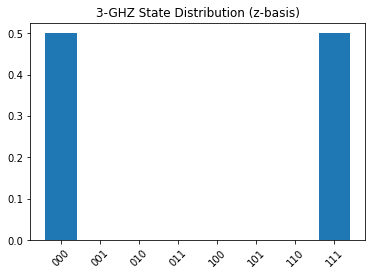

In [3]:
"""[Notes on the states]

Confusingly, the cluster state is actually NUM_QUBITS^2 qubits rather than NUM_QUBITS. 
This is due to the way the circuit is designed. The rest are as you would expect.
"""

if STATE_TYPE == 'GHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from GHZ_generator import GHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = GHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'mGHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from mGHZ_generator import mGHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = mGHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'XY':
    # Prepare: XY(L) (from: ED)
    from XY_generator import xy_ground_state
    state = Statevector(xy_ground_state(NUM_QUBITS).numpy())
elif STATE_TYPE == 'Cluster':
    # Prepare cluster(L) (from: Q-circuit)
    from cluster_generator import cluster_state_circuit
    state = Statevector.from_int(0, 2**(NUM_QUBITS**2))
    qc = cluster_state_circuit(NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
else:
    raise TypeError("Invalid state type specified.")
param_shape = (state.num_qubits, CIRCUIT_DEPTH+1, PARAM_PER_QUBIT_PER_DEPTH)

# Visualize the distribution
plt.bar(qubit_expansion(state.num_qubits), state.probabilities())
plt.xticks(rotation=45)
plt.title(f"{NUM_QUBITS}-{STATE_TYPE} State Distribution (z-basis)")
plt.show()

In [4]:
# Preparation of two bases
bases = prepare_basis(state.num_qubits, num=NUM_BASES)
num_bases = len(bases)

Classical deep net of circuit depth 0 initialized.
Classical deep net of circuit depth 0 initialized.
3-qubit (noise: 0) regularized 'Nelder-Mead' hybrid quantum net initialized -- Hello world!


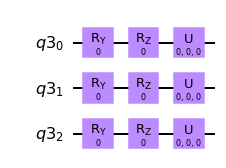

In [5]:
# Start up the HQN
disp = False # Display convergence messages from optimizer

hqn = HQNet(state, bases, eta=1e-2, maxiter=1E4, disp=disp,
            mode='Nelder-Mead', depth=CIRCUIT_DEPTH, 
            estimate=ESTIMATE, s_eps=NOISE_SCALE, 
            metric_func=LOSS_METRIC, ops=OPS, sample=SAMPLE, 
            regularize=USE_REGULARIZER)

# Examine the parametrized circuit
hqn.view_circuit().draw(output='mpl')

In [6]:
# Optimize a few times.
NRUN = 5
param_dim = np.prod(param_shape)
proposed_syms = t.zeros((NRUN, param_dim))
avg = 0
# x0 = np.array([3.1416, 1.8676, 3.9111, 3.1416, 0.0572, 3.4207, 3.1416, 1.2177, 8.6164]) # Off diag
x0 = np.array([6.2832, 4.6871, 1.5150, 6.2832, 6.8319, 1.4635, 6.2832, 7.3298, 2.4352]) # diag
# x0 = None # random
for i in range(NRUN):
    if disp:
        print(f"== Run {i+1}/{NRUN} ==")
    potential_sym, loss, regularizer_loss = hqn.find_potential_symmetry(print_log=True, x0=x0)
    if USE_REGULARIZER:
        print(f"Regularizer loss = {regularizer_loss}")
    proposed_syms[i] = potential_sym if t.is_tensor(potential_sym) else t.from_numpy(potential_sym)
    potential_sym = potential_sym.reshape(param_shape)
    if disp:
        print(f"Proposed symmetry:\n{potential_sym}\n")
    avg += loss / NRUN
print(f"\nAverage loss: {avg}")

Optimized to loss metric = 0.07719938891626578
Queried loss func 4474 times
True QKL's = tensor([0.0283, 0.0276])
Predicted QKL's = tensor([-0.0006, -0.0013])
MSE = tensor([0.0008, 0.0008])
[CNet] Training 4474 points...
[CNet] Training 4474 points...
Regularizer loss = 0.021268180261027628
Optimized to loss metric = 2.429796791255296e-15
Queried loss func 1581 times
True QKL's = tensor([-5.7789e-16,  2.3915e-15])
Predicted QKL's = tensor([0.0640, 0.0640])
MSE = tensor([0.0041, 0.0041])
[CNet] Training 1581 points...
[CNet] Training 1581 points...
Regularizer loss = 6.161863311040581e-16
Optimized to loss metric = 0.04400190903438354
Queried loss func 2377 times
True QKL's = tensor([2.3757e-02, 1.1477e-06])
Predicted QKL's = tensor([-0.0052, -0.1563])
MSE = tensor([0.0008, 0.0244])
[CNet] Training 2377 points...
[CNet] Training 2377 points...
Regularizer loss = 0.020243359440902647
Optimized to loss metric = 0.03870512783073787
Queried loss func 1220 times
True QKL's = tensor([1.3699e-

## Quantum Training Validation

In [7]:
# Look at the final KL divergence in each of the chosen bases.
for i, sym in enumerate(proposed_syms):
    for j, basis_here in enumerate(bases):
        loss_metric = PQC(state, depth=CIRCUIT_DEPTH, basis_param=basis_here, 
                          metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"[B{j}] KL = {loss_metric}")

[B0] KL = 0.028329584408381417
[B1] KL = 0.027601641276340873
[B0] KL = -5.01717339444277e-16
[B1] KL = 4.181902307464641e-14
[B0] KL = 0.023757441487043236
[B1] KL = 1.1477108451014715e-06
[B0] KL = 1.3685320132684809e-08
[B1] KL = 0.007066235875413543
[B0] KL = 0.003263189506236581
[B1] KL = 0.007728510113445631


## Quantum Loss Cross-Validation

In [8]:
# Choose some random bases to examine.
NUM_RAND_BASES = 3 # arbitrary
for i, sym in enumerate(proposed_syms):
    for j in range(NUM_RAND_BASES):
        basis_here = rand_basis(state.num_qubits)
        loss_metric = PQC(state, depth=CIRCUIT_DEPTH, basis_param=basis_here, 
                          metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"[B{j}] KL = {loss_metric}")

[B0] KL = 0.364370470482245
[B1] KL = 0.07127542666926742
[B2] KL = 0.031032611953007747
[B0] KL = 1.131378332902631e-07
[B1] KL = 1.700117401911354e-07
[B2] KL = 2.3574134358998457e-10
[B0] KL = 0.05281387756110714
[B1] KL = 0.007251789495495592
[B2] KL = 0.035810758873050394
[B0] KL = 0.3944133731878213
[B1] KL = 0.005299857123607912
[B2] KL = 0.026693556061623172
[B0] KL = 0.0018738047221613105
[B1] KL = 0.4410793060733089
[B2] KL = 0.0012663212038566674


## Regularization validation

In [9]:
def param_to_unitary(param):
    L = param.shape[0]
    unitaries = np.zeros((L, 2, 2), dtype=np.complex_)
    for i in range(L):
        theta, phi, lamb = param[i]
        unitaries[i,0,0] = np.cos(theta/2)
        unitaries[i,0,1] = -np.exp(1j*lamb) * np.sin(theta/2)
        unitaries[i,1,0] = np.exp(1j*phi) * np.sin(theta/2)
        unitaries[i,1,1] = np.exp(1j*(lamb+phi)) * np.cos(theta/2)
    return unitaries

In [10]:
# Convert the proposed symmetries to unitaries
for i, sym in enumerate(proposed_syms):
    sym = sym.reshape((NUM_QUBITS, -1)).numpy()
    unitary = np.around(param_to_unitary(sym), 4)
    print(f"[S{i}] Operator = \n {unitary}")

[S0] Operator = 
 [[[-0.9949+0.j     -0.0766+0.0658j]
  [-0.0111+0.1004j -0.5612-0.8215j]]

 [[-0.9972+0.j     -0.0298+0.0687j]
  [-0.0721+0.0202j  0.1356-0.9879j]]

 [[-0.9938+0.j      0.0422+0.103j ]
  [-0.0961-0.0562j  0.1391-0.984j ]]]
[S1] Operator = 
 [[[-1.    +0.j      0.    -0.j    ]
  [ 0.    +0.j      0.9953-0.0967j]]

 [[-1.    +0.j      0.    +0.j    ]
  [ 0.    -0.j      0.5924+0.8056j]]

 [[-1.    +0.j      0.    -0.j    ]
  [-0.    -0.j     -0.9796+0.201j ]]]
[S2] Operator = 
 [[[-9.904e-01+0.000e+00j  1.355e-01+2.800e-02j]
  [-5.950e-02-1.249e-01j -2.364e-01-9.618e-01j]]

 [[-1.000e+00+0.000e+00j  1.000e-04+0.000e+00j]
  [ 1.000e-04-1.000e-04j  9.944e-01-1.056e-01j]]

 [[-9.978e-01+0.000e+00j -3.170e-02+5.840e-02j]
  [-1.350e-02+6.510e-02j -7.616e-01-6.446e-01j]]]
[S3] Operator = 
 [[[-1.000e+00+0.000e+00j -0.000e+00-1.000e-04j]
  [ 1.000e-04+1.000e-04j  7.078e-01-7.064e-01j]]

 [[-1.000e+00+0.000e+00j  2.000e-04+1.000e-04j]
  [-2.000e-04-0.000e+00j -8.505e-01-5.260e-0

In [11]:
print(proposed_syms[0])

tensor([6.4855, 4.8229, 2.4317, 6.4330, 6.0105, 1.9798, 6.5063, 0.5292, 1.1820])
